# Homework 2

We first import the needed libraries and set the elements we need for the rest of the Homework.

In [1]:
# Used to look for the saved rankings
DATA_FOLDER = 'Data/'

In [2]:
# Importing libraries
import re #for regexes
import requests
import numpy as np
import unicodedata #useful for ex 3
import pickle as pk
import pandas as pd
import seaborn as sns
import os, os.path as osp
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [3]:
# We set a few things for seaborn to have uniform plots in the notebook
sns.set(style="darkgrid")
sns.set_context("notebook")
sns.set_palette("RdPu_d", 10)

## Useful functions

The following functions are helper functions allowing us to have a cleaner code

In [4]:
#Functions allowing us to manipulate Pickle files (faster running time)
def save_pkl(obj, path):
    """Saves into a pickle file to given path."""
    with open(path, 'wb') as f:
        pk.dump(obj, f)  
        
def load_pkl(path):
    """Loads a pickle file from a given path."""
    with open(path, 'rb') as f:
        return pk.load(f)

In [5]:
#Functions allowing us to clean our data
def transform_rank(df, cname):
    """Function that transforms the rank from a string to an int. 
    We also use it to define a relative and an absolute ranking"""
    
    df.rename(columns = {cname: 'relative_rank'}, inplace = True)
    df['absolute_rank'] = df.index + 1
    
    #The assert is needed to ensure that we have strings (else the code produces errors).
    assert df['relative_rank'].dtype == np.object_, "We do not have strings in " + 'relative_rank'
    df['relative_rank'] = df['relative_rank'].str.replace(r'\D+', '').astype('int')
    
def remove_blank_convert_float(x):
    """Removes blankspace from x and parses it to float."""
    if(x):
        x = x.text[1:-1].replace(",","")
        x_float = float(x)
    else:
        #Using NAN for unknown values to facilitate computation
        x_float = float('NAN')
    return x_float

In [6]:
#As we need to compute several ratios, we decided to modularize this operation
def ratios_calc(df, c1, c2, name):
    """Function that computes ratios for a given DataFrame.
        df is the DataFrame
        c1 is the name of the first column for the ratio,
        c2 is the name of the second column for the ratio,
        name is the name of the new column
    """
    # Computes the ratio and puts it in a new column
    df[name] = df[c1]/df[c2]

## Preparatory steps

The first step was a preliminary exploration of the website's responses and code using Postman and the Google Chrome dev tools.

- For the Times, looking at the JSON response from the ranking website immediately led to the right data.
- For TopUniversities, we searched for through occurence of "qs-rankings data" on Postman, and found the url linking to the source of the data.
- To find the additional information needed in the TopUniversities set, we used the Google dev tools to quickly check which html classes pointed to the div tags containing the required information.

In [7]:
#Base URL for websites to crawl
FILES = '/sites/default/files/'
TOP_UNIVERSITIES = 'https://www.topuniversities.com'
TIMES_EDUCATION = 'https://www.timeshighereducation.com'

#These are the main URLs we will be working with
TOP_UNIVERVERSITIES_TEXT = TOP_UNIVERSITIES + FILES + 'qs-rankings-data/357051.txt'
TIMES_EDUCATION_JSON = TIMES_EDUCATION + FILES + 'the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

## Exercise 1 : TopUniversities

### Data retrieval
The first step is pretty straight forward. We simply request the JSON and create a DataFrame containing all the needed information offered by the request.

In [8]:
s = requests.get(TOP_UNIVERVERSITIES_TEXT)
topjson = s.json()

In [9]:
top_frame = pd.DataFrame(topjson['data']).head(200)
#remove useless columns
del top_frame['cc'],\
    top_frame['logo'],\
    top_frame['nid'],\
    top_frame['core_id'],\
    top_frame['stars'],\
    top_frame['guide']

#This step allows us to clean the (relative) rank for comparison and add an (absolute) rank for display
transform_rank(top_frame,'rank_display')
    
#Allows us to have a quick look at the data.
top_frame.head()

,country,relative_rank,region,score,title,url,absolute_rank
0,United States,1,North America,100,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,1
1,United States,2,North America,98.7,Stanford University,/universities/stanford-university,2
2,United States,3,North America,98.4,Harvard University,/universities/harvard-university,3
3,United States,4,North America,97.7,California Institute of Technology (Caltech),/universities/california-institute-technology-...,4
4,United Kingdom,5,Europe,95.6,University of Cambridge,/universities/university-cambridge,5


The second step is a little more complicated, which is why we decided to include an example of how additional data should be retrieved in order to better understand our methodology.

In [10]:
r = requests.get(TOP_UNIVERSITIES + '/universities/university-cambridge')
page_body = r.text
soup = BeautifulSoup(page_body, 'html.parser')

#In order to get the right numbers, we use [1:-1] in order to delete the leading and trailing spaces
student_number = (soup.find('div', class_='total student')).find('div', class_='number').text[1:-1]
int_student = (soup.find('div', class_='total inter')).find('div', class_='number').text[1:-1]
facult_number = (soup.find('div', class_='total faculty')).find('div', class_='number').text[1:-1]
int_faculty = (soup.find('div', class_='inter faculty')).find('div', class_='number').text[1:-1]

#We create a new DataFrame to visualize the new information
pd.DataFrame.from_dict({'students' : [student_number], 
              'international students': [int_student], 
              'faculty' : [facult_number], 
              'international faculty' : [int_faculty] })

,faculty,international faculty,international students,students
0,"5,490","2,278","6,699","18,770"


The following function allows us to get all the useful information. As asked, we make sure that we have the name, rank, country, region, number of faculty members (international and total) and number of students (international and total) in the final DataFrame.

In [11]:
def get_additional_info(url):
    r = requests.get(TOP_UNIVERSITIES + url)
    assert r.status_code != 404, 'Bad request: could not get data'
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    
    #In the following steps, we make sure the values exist before fetching them
    student_number = (soup.find('div', class_='total student')) 
    if student_number:
        student_number = student_number.find('div', class_='number')
        
    int_student = (soup.find('div', class_='total inter'))
    if int_student:
        int_student = int_student.find('div', class_='number')
    
    faculty_number = (soup.find('div', class_='total faculty'))
    if faculty_number:
        faculty_number = faculty_number.find('div', class_='number')
        
    int_faculty = (soup.find('div', class_='inter faculty'))
    if int_faculty:
        int_faculty = int_faculty.find('div', class_='number')
    
    frame = pd.DataFrame.from_dict({'students' : [remove_blank_convert_float(student_number)], 
              'international students': [remove_blank_convert_float(int_student)], 
              'faculty' : [remove_blank_convert_float(faculty_number)], 
              'international faculty' : [remove_blank_convert_float(int_faculty)] })
    return frame

In [12]:
#Takes a relatively long time to run when pickle file is not present

#We create a folder to store all the data.
if not osp.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

#We create a file to store the TopUniversities Ranking
top_file = DATA_FOLDER + 'top_ranking.pkl'
if osp.exists(top_file):
    top_frame = load_pkl(top_file)
else:
    missing_rows = pd.DataFrame()
    for url in top_frame.url:
        new_info = get_additional_info(url)
        missing_rows = missing_rows.append(new_info, ignore_index = True)
    #We simply concatenate all the information and sort them in order to have a better layout similar to the one below
    top_frame = pd.concat([top_frame, missing_rows], axis=1, join_axes=[top_frame.index])
    top_frame.rename(columns = {'title': 'name'}, inplace = True)
    top_frame = top_frame.reindex_axis(['country', 'region', 'name', 'score', 'relative_rank',
                                         'absolute_rank', 'international faculty', 'faculty',
                                         'international students', 'students', 'url'], axis=1)
    save_pkl(top_frame, top_file)

We have a few undefined values in the final "top_frame" set due to the lack of information on the website (data is not present), so we simply propagate NAN values.

### Best universities by ratio :
We first determine which universities are the best according to the faculty/student ratio (and display the top of the list). To do that, we create a new DataFrame only containing the relevant information (university, ratio and relative rank for display).

In [13]:
top_fac_stud = top_frame
ratios_calc(top_fac_stud , 'faculty', 'students', 'faculty/students')
top_fac_stud = top_fac_stud[['name', 'faculty/students', 'relative_rank']]

In [14]:
top_fac_stud = top_fac_stud.sort_values(['faculty/students', 'relative_rank'], ascending=[False, True])
top_fac_stud = top_fac_stud.reset_index()
top_fac_stud.head()

,index,name,faculty/students,relative_rank
0,3,California Institute of Technology (Caltech),0.422616,4
1,15,Yale University,0.398323,16
2,5,University of Oxford,0.342292,6
3,4,University of Cambridge,0.292488,5
4,16,Johns Hopkins University,0.276353,17


Here we determine the ratio of international/total students. We use a similar method as before to obtain these numbers.

In [15]:
top_int_stud = top_frame
ratios_calc(top_int_stud,'international students', 'students', 'international/students')
top_int_stud = top_int_stud[['name', 'international/students', 'relative_rank']]

In [16]:
top_int_stud = top_int_stud.sort_values(['international/students', 'relative_rank'], ascending=[False, True])
top_int_stud = top_int_stud.reset_index()
top_int_stud.head()

,index,name,international/students,relative_rank
0,34,London School of Economics and Political Scien...,0.691393,35
1,11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047,12
2,7,Imperial College London,0.543567,8
3,198,Maastricht University,0.502533,200
4,47,Carnegie Mellon University,0.478062,47


To better understand and visualize the top universities according to each ration, we plot the top [10, 20, 30, 40] universities. We note a pattern appears when plotting more than only the top 10. For better readability we show the top 20. The observations are described below. 

In [17]:
best_fac = top_fac_stud.head(20)
best_int = top_int_stud.head(20)

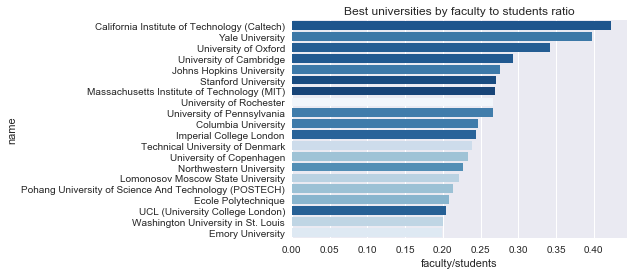

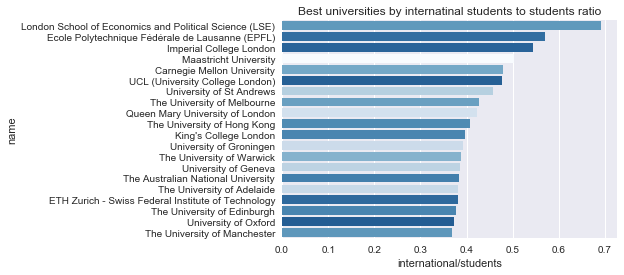

In [18]:
cmap = plt.cm.get_cmap('Blues')
pal = sns.color_palette("RdPu", n_colors=14, desat=0.6)

#the mapping is used to get a nice color interpolation, the darker the color the better the university
sns.barplot(y="name", x="faculty/students", palette=best_fac['relative_rank'].map(lambda x: cmap(1-np.sqrt(1+(x - 200)/200))) , data=best_fac)
plt.title("Best universities by faculty to students ratio")
plt.show()

sns.barplot(y="name", x="international/students", palette=best_int['relative_rank'].map(lambda x: cmap(1-np.sqrt(1+(x - 200)/200))) , data=best_int)
plt.title("Best universities by internatinal students to students ratio")
plt.show()

First note that the darkness of the bar represents the position in the original ranking. The darker the better.
By plotting the first 20 we can observe through looking at the color that the top 10 universities by faulty/student ratio are almost all ranked in the top of the general ranking as well.

We note that no such pattern can be observed by plotting the student/international student ratio.

### Best universities by geographic location :
We begin by sorting the countries by their number of universities in the 200 top schools.

In [19]:
best_countries = pd.DataFrame(top_frame['country'].value_counts())
best_countries = best_countries.reset_index()
best_countries.columns = ['country', 'universities']
best_countries.head()

,country,universities
0,United States,47
1,United Kingdom,28
2,Germany,11
3,Netherlands,10
4,Japan,9


We perform the same actions for the regions we have

In [20]:
best_regions = pd.DataFrame(top_frame['region'].value_counts())
best_regions = best_regions.reset_index()
best_regions.columns = ['region', 'universities']
best_regions.head()

,region,universities
0,Europe,89
1,North America,54
2,Asia,38
3,Oceania,11
4,Latin America,7


Finally we plot the best regions and countries.

In [21]:
best_countries = best_countries.head(10)

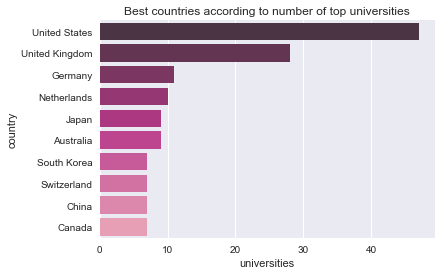

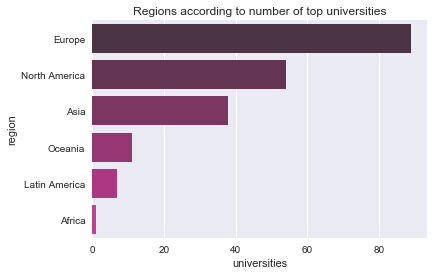

In [22]:
sns.barplot(y='country', x='universities', data=best_countries)
plt.title("Best countries according to number of top universities")
plt.show()

sns.barplot(y="region", x="universities", data=best_regions)
plt.title("Regions according to number of top universities")
plt.show()

We can observe that the best schools lie in first world countries, with western countries being on the top. This is also reflected when sorting by region.

## Exercise 2 : Times Higher Education

In the following exercise, we mostly do the same steps as for the first exercise. Thus, we will not precise each step (except for different handlings of the data).

### Data retrieval

In [23]:
r = requests.get(TIMES_EDUCATION_JSON)
timesjson = r.json()

In [24]:
times_frame = pd.DataFrame(timesjson['data']).head(200) #Keep the first 200 schools
times_frame = times_frame[[d for d in times_frame.columns if not ('score' in d)]] #Drop useless frames
del times_frame['member_level'],\
    times_frame['nid'],\
    times_frame['record_type'],\
    times_frame['subjects_offered'],\
    times_frame['stats_female_male_ratio'],\
    times_frame['rank_order']

transform_rank(times_frame,'rank')
times_frame.rename(columns = {'stats_number_students': 'students', 
                    'stats_pc_intl_students': 'international/students',
                    'stats_student_staff_ratio': 'faculty/students',
                    'location': 'country'}, inplace = True)    

times_frame.head()

,aliases,country,name,relative_rank,students,international/students,faculty/students,url,absolute_rank
0,University of Oxford,United Kingdom,University of Oxford,1,"20,409",38%,11.2,/world-university-rankings/university-oxford,1
1,University of Cambridge,United Kingdom,University of Cambridge,2,"18,389",35%,10.9,/world-university-rankings/university-cambridge,2
2,California Institute of Technology caltech,United States,California Institute of Technology,3,"2,209",27%,6.5,/world-university-rankings/california-institut...,3
3,Stanford University,United States,Stanford University,3,"15,845",22%,7.5,/world-university-rankings/stanford-university,4
4,Massachusetts Institute of Technology,United States,Massachusetts Institute of Technology,5,"11,177",34%,8.7,/world-university-rankings/massachusetts-insti...,5


### Data cleaning :

There is a very big difference between the TopUniversities ranking and the Times Higher Education ranking when it comes to ratios, they are already provided to us. For this reason, we need to format these elements so they can be easily used. We then display the head to ensure the results are sound.

In [25]:
times_frame['faculty/students'] = 1/times_frame['faculty/students'].astype('float')
times_frame['international/students'] = (1/100) * times_frame['international/students'].str.replace('%', '').astype('int')
times_frame.head()

,aliases,country,name,relative_rank,students,international/students,faculty/students,url,absolute_rank
0,University of Oxford,United Kingdom,University of Oxford,1,"20,409",0.38,0.089286,/world-university-rankings/university-oxford,1
1,University of Cambridge,United Kingdom,University of Cambridge,2,"18,389",0.35,0.091743,/world-university-rankings/university-cambridge,2
2,California Institute of Technology caltech,United States,California Institute of Technology,3,"2,209",0.27,0.153846,/world-university-rankings/california-institut...,3
3,Stanford University,United States,Stanford University,3,"15,845",0.22,0.133333,/world-university-rankings/stanford-university,4
4,Massachusetts Institute of Technology,United States,Massachusetts Institute of Technology,5,"11,177",0.34,0.114943,/world-university-rankings/massachusetts-insti...,5


We also have the probblem that the Times Higher Education ranking does not include the region. Thus, we decide to match the countries using the regions defined by the first ranking. 

In [26]:
regions_by_country = dict(zip(top_frame.country, top_frame.region))

Some countries couldn't be matched automatically

In [27]:
times_frame['region'] = times_frame.country.map(regions_by_country)
times_frame[times_frame.region.isnull()]

,aliases,country,name,relative_rank,students,international/students,faculty/students,url,absolute_rank,region
178,University of Luxembourg,Luxembourg,University of Luxembourg,179,"4,969",0.57,0.068493,/world-university-rankings/university-luxembourg,179,NaN
193,Lomonosov Moscow State University,Russian Federation,Lomonosov Moscow State University,194,"29,236",0.22,0.136986,/world-university-rankings/lomonosov-moscow-st...,194,NaN


In [28]:
#Both universities are in Europe, so we input the region manually
times_frame.loc[times_frame.region.isnull(), 'region'] = 'Europe' 
times_frame.head()

,aliases,country,name,relative_rank,students,international/students,faculty/students,url,absolute_rank,region
0,University of Oxford,United Kingdom,University of Oxford,1,"20,409",0.38,0.089286,/world-university-rankings/university-oxford,1,Europe
1,University of Cambridge,United Kingdom,University of Cambridge,2,"18,389",0.35,0.091743,/world-university-rankings/university-cambridge,2,Europe
2,California Institute of Technology caltech,United States,California Institute of Technology,3,"2,209",0.27,0.153846,/world-university-rankings/california-institut...,3,North America
3,Stanford University,United States,Stanford University,3,"15,845",0.22,0.133333,/world-university-rankings/stanford-university,4,North America
4,Massachusetts Institute of Technology,United States,Massachusetts Institute of Technology,5,"11,177",0.34,0.114943,/world-university-rankings/massachusetts-insti...,5,North America


Once our data is ready, we save all the needed elements in a new file

In [29]:
#We create a file to store the Times Higher Education Ranking
times_file = DATA_FOLDER + 'times_ranking.pkl'
if osp.exists(times_file):
    times_frame = load_pkl(times_file)
else:
    times_frame = times_frame.reindex_axis(['country', 'region', 'name', 'aliases', 'relative_rank',
                                         'absolute_rank', 'faculty/students', 'international/students', 
                                         'students', 'url'], axis=1)
    save_pkl(times_frame, times_file)

### Best universities by ratio :

We visualize the best universities according to their ratios (after sorting them).

In [30]:
best_fac = times_frame[['name', 'faculty/students', 'relative_rank']]
best_fac = times_frame.sort_values(['faculty/students', 'relative_rank'], ascending=[False, True])
best_fac.index = range(len(best_fac.index))


In [31]:
best_int = best_int[['name', 'international/students', 'relative_rank']]
best_int = best_int.sort_values(['international/students', 'relative_rank'], ascending=[False, True])
best_int = best_int.reset_index()


In [32]:
best_fac = best_fac.head(20)
best_int = best_int.head(20)

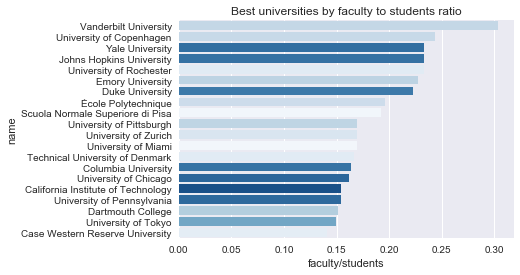

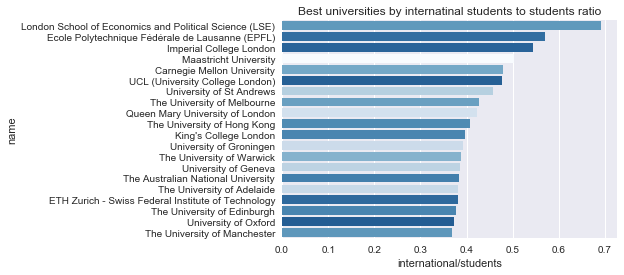

In [33]:
cmap = plt.cm.get_cmap('Blues')
pal = sns.color_palette("RdPu", n_colors=14, desat=0.6)

sns.barplot(y="name", x="faculty/students", palette=best_fac['relative_rank'].map(lambda x: cmap(1-np.sqrt(1+(x - 200)/200))) , data=best_fac)
plt.title("Best universities by faculty to students ratio")
plt.show()

sns.barplot(y="name", x="international/students", palette=best_int['relative_rank'].map(lambda x: cmap(1-np.sqrt(1+(x - 200)/200))) , data=best_int)
plt.title("Best universities by internatinal students to students ratio")
plt.show()

Interestingly, the faculty to student ratio in the Times ranking seems to contain very different values, as well different lower ranking universities (which a higher fac/stud ratio), hence we can not observe a similar distribution as for the Top Universities ranking.

The international student to student ratio, however, is similarly distributed.

### Best universities by geographic region :

Unlike the TopUniversities ranking, the Times Higher Education ranking does not include the region. We previously used to mapping defined in TopUniversities to map countries in Times to the regions.

This is the ranking by country.

In [34]:
best_countries = pd.DataFrame(times_frame['country'].value_counts())
best_countries = best_countries.reset_index()
best_countries.columns = ['country', 'universities']
best_countries.head()

,country,universities
0,United States,62
1,United Kingdom,31
2,Germany,20
3,Netherlands,13
4,Australia,8


This is the ranking by region.

In [35]:
best_regions = pd.DataFrame(times_frame['region'].value_counts())
best_regions = best_regions.reset_index()
best_regions.columns = ['region', 'universities']
best_regions.head()

,region,universities
0,Europe,101
1,North America,68
2,Asia,21
3,Oceania,9
4,Africa,1


Finally, we plot our results

In [36]:
best_countries = best_countries.head(10)

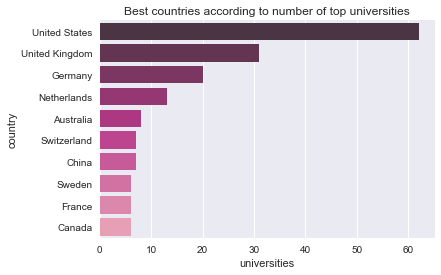

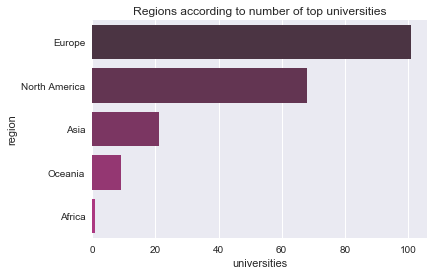

In [37]:
sns.barplot(y='country', x='universities', data=best_countries)
plt.title("Best countries according to number of top universities")
plt.show()

sns.barplot(y="region", x="universities", data=best_regions)
plt.title("Regions according to number of top universities")
plt.show()

We note that similarly to the topuniversities ranking, first world, mostly western countries fare the best. We can see that while the Top Universities ranking didn't contain any african universities, the Times ranking does. But unlike the Top Universities ranking, it does not seem to contain any latin american universities.

## Exercise 3 :  Merging the two rankings

### Naive Merge

We tried to merge the two DataFrames in a naive manner with a simple join, and found that barely any columns matched.

We also tried to use difflib, a Python library, but it gives us false positives for certain universities. If it gave us false negatives, it wouldn't be a huge problem, but the opposite is one as we don't want any errors in our mergers. 

Hence, we created our own method. The idea behind this is that non-alphanumeric characters in the strings make it so that the strings are not an exact match. It also happens that some university names in one DataFrame are a substring of those in the other.

For some languages (french and german for example), non-unicode characters (like é and è or ö and ü) impede the matching. Thus, removing all these may increase our matching rate, without giving us any false positives.

In [38]:
def ascii(s):
    s = re.sub("\W+", "", s)
    s = s.replace("at", '')
    # transforms é with e for example
    return ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'))

#apply the transformation to both frames
top_frame.name = top_frame.name.map(str.lower).map(ascii)
times_frame.name = times_frame.name.map(str.lower).map(ascii)

We create a dictionary with the different matches, making sure to fill it from both sides (check if a is in b and if b is in a). As we sometimes have multiple matches, it is best not to do anything right now at the risk of getting false positives.

In [39]:
i = 0
university_name = dict()

for name in times_frame['name']:
    if (top_frame['name'].str.contains(name).any()) \
    and len(top_frame.name[top_frame['name'].str.contains(name)]) == 1:
        #way to check how many direct matches we have
        university_name[name] = top_frame.name[top_frame['name'].str.contains(name)].item()
        #matches_1.append(top_frame.name[top_frame['name'].str.contains(name)].item())
        i = i+1
        
    #if we have multiple possibilities, take exact match if it exists
    elif (top_frame['name'].str.contains(name).any()) \
    and len(top_frame.name[top_frame['name'].str.contains(name)]) != 1\
    and not top_frame.name[top_frame['name'] == name].empty:
        university_name[name] = top_frame.name[top_frame['name'] == name]
#Number of matches.
len(university_name)

146

In [40]:
# Mostly the same but the other way around.
i = 0

for name in top_frame['name']:
    if times_frame['name'].str.contains(name).any()\
    and len(times_frame.name[times_frame['name'].str.contains(name)]) == 1:
        university_name[times_frame.name[times_frame['name'].str.contains(name)].item()] = name
        i = i+1
    elif (times_frame['name'].str.contains(name).any()) \
    and len(times_frame.name[times_frame['name'].str.contains(name)]) != 1\
    and not times_frame.name[times_frame['name'] == name].empty:
        university_name[times_frame.name[times_frame['name'] == name].item()] = name
#Number of matches.
len(university_name)

148

As we can see, we only have 148 matches, which leaves us with (at least) 52 unmatches universities.

### Specific Cases

We decided to take a look at all the unmatched universities to see if we can do better.

In [41]:
times_frame['join_here'] = times_frame.name.map(university_name)
still_na = times_frame[times_frame['join_here'].isnull()]
inv_unimap = {v: k for k, v in university_name.items()} #inverse dictionary
top_frame['join_here'] = top_frame.name.map(inv_unimap)
top_na = top_frame[top_frame['join_here'].isnull()]

We go through each country to check if there are any unmatched universities or if they exist in only one of the rankings. This will allow us to understand the difficulties in each one of them. We could use the aliases, but in reality, they do not help for matching.

In [42]:
#This set gives us the set of countries for which both frames have unmatched universities
na_countries = set(top_na.groupby('country').size().index).intersection(set(still_na.groupby('country').size().index))
na_countries

{'Belgium',
 'Canada',
 'France',
 'Germany',
 'Hong Kong',
 'South Korea',
 'Spain',
 'Sweden',
 'United Kingdom'}

In [43]:
def print_universities(country):
    """prints universities from the same country"""
    print(country, "\n")
    print("TopUniversities university names :")
    print(top_na[top_na.country == country].name)
    print("\nTimes Higher Education university names")
    print(still_na[still_na.country == country].name)

Concerning Belgium, we have no possible matches between the 2 rankings.

In [44]:
print_universities("Belgium")

Belgium 

TopUniversities university names :
181    vrijeuniversiteitbrusselvub
Name: name, dtype: object

Times Higher Education university names
174    universitelibredebruxelles
Name: name, dtype: object


In Canada, the main issue of merging is the use of the university name in a different language.

In [45]:
print_universities("Canada")

Canada 

TopUniversities university names :
129    universitedemontreal
151      universityofwerloo
Name: name, dtype: object

Times Higher Education university names
107    universityofmontreal
Name: name, dtype: object


Once again in France, the only possible merges are prevented because of the use of the university name in a different language.

In [46]:
print_universities("France")

France 

TopUniversities university names :
42          ecolenormalesuperieureparis
130    universitepierreetmariecurieupmc
176                     centralesupelec
Name: name, dtype: object

Times Higher Education university names
72     parissciencesetlettrespslresearchuniversityparis
123                       pierreandmariecurieuniversity
180                                  parissuduniversity
195                       parissorbonneuniversityparis4
Name: name, dtype: object


We see that matchings in Germany can be improved a lot because of naming conventions in Germany impede on the matching.

In [47]:
print_universities("Germany")

Germany 

TopUniversities university names :
65     ludwigmaximiliansuniversitatmunchen
67      ruprechtkarlsuniversitatheidelberg
119            humboldtuniversitatzuberlin
124                freieuniversitaetberlin
143    technischeuniversitatberlintuberlin
165       eberhardkarlsuniversitattubingen
170      albertludwigsuniversitaetfreiburg
Name: name, dtype: object

Times Higher Education university names
34                            lmumunich
44                 heidelberguniversity
61           humboldtuniversityofberlin
81                 universityoffreiburg
87               freeuniversityofberlin
91          technicaluniversityofberlin
93                 universityoftubingen
99                     universityofbonn
124                universityofmannheim
126    chariteuniversitatsmedizinberlin
144                 universityofcologne
155                           tudresden
156                       ulmuniversity
163       universityoferlangennuremberg
166                universi

This university always matches with 2 other universities (needs to be done manually).

In [48]:
print_universities("Hong Kong")

Hong Kong 

TopUniversities university names :
25    theuniversityofhongkong
Name: name, dtype: object

Times Higher Education university names
39    universityofhongkong
Name: name, dtype: object


The only string that can be matched is not written in the same order in both rankings.

In [49]:
print_universities("South Korea")

South Korea 

TopUniversities university names :
40     kaistkoreaadvancedinstituteofsciencetechnology
89                                    koreauniversity
105                                  yonseiuniversity
154                                 hanyanguniversity
Name: name, dtype: object

Times Higher Education university names
95    koreaadvancedinstituteofscienceandtechnologykaist
Name: name, dtype: object


Once again, universities in Spain cannot be merged because of translation issues.

In [50]:
print_universities("Spain")

Spain 

TopUniversities university names :
155            universitdebarcelona
186     universidadautonomademadrid
195    universitautonomadebarcelona
Name: name, dtype: object

Times Higher Education university names
139              pompeufabrauniversity
146    autonomousuniversityofbarcelona
Name: name, dtype: object


These universities are all distinct.

In [51]:
print_universities("Sweden")

Sweden 

TopUniversities university names :
132    chalmersuniversityoftechnology
Name: name, dtype: object

Times Higher Education university names
38        karolinskainstitute
198    universityofgothenburg
Name: name, dtype: object


Finally, in the United Kingdom, we have no possible matches between the universities.

In [52]:
print_universities("United Kingdom")

United Kingdom 

TopUniversities university names :
159         universityofbh
188    universityofreading
Name: name, dtype: object

Times Higher Education university names
148                 universityofsussex
158              universityofleicester
186                 universityofdundee
187             universityofeastanglia
196    royalhollowayuniversityoflondon
Name: name, dtype: object


We tried to match the universities using their number of students. However, we were unable to use this method because the difference between the number of students between the two rankings was too big.

After this, we decided to match them manually by adding them to the dictionary.

In [53]:
#times.name = top.name
university_name['universityofmontreal'] = 'universitedemontreal'
university_name['pierreandmariecurieuniversity'] = 'universitepierreetmariecurieupmc'
university_name['lmumunich'] = 'ludwigmaximiliansuniversitatmunchen'
university_name['humboldtuniversityofberlin'] = 'humboldtuniversitatzuberlin'
university_name['freeuniversityofberlin'] = 'freieuniversitaetberlin'
university_name['heidelberguniversity'] = 'ruprechtkarlsuniversitatheidelberg'
university_name['universityoftubingen'] = 'eberhardkarlsuniversitattubingen'
university_name['technicaluniversityofberlin'] = 'technischeuniversitatberlintuberlin'
university_name['universityoffreiburg'] = 'albertludwigsuniversitaetfreiburg'
university_name['universityofhongkong'] = 'theuniversityofhongkong'
university_name['koreaadvancedinstituteofscienceandtechnologykaist'] = 'kaistkoreaadvancedinstituteofsciencetechnology'
university_name['autonomousuniversityofbarcelona'] = 'universitautonomadebarcelona'

In [54]:
len(university_name)

160

we can match 160 out of the 200 universities

### Final merging

We start by adding a column to enable the merging of the two rankings.

Note that we decided on an inner join, as we will only take the universities in both rankings in this new DataFrame.

In [55]:
times_frame['join_here'] = times_frame.name.map(university_name)
merged_frame = pd.merge(times_frame, top_frame, how='inner', left_on=['join_here'], right_on=['name'])

In [56]:
#quick renaming for more convenient reading later
merged_frame = merged_frame.rename(columns={'international/students_x': 'times: international/students',
                                            'international/students_y': 'topunis: international/students',
                                            'faculty/students_x': 'times: faculty/students',
                                            'faculty/students_y': 'topunis: faculty/students',
                                            'relative_rank_x': 'times rank',
                                            'relative_rank_y': 'topunis rank',
                                           })

We can see that we could indeed find 160 matchings thanks to the dictionary method

## Exercise 4 : Exploratory Analysis

### Individual correlation

The first step of our exploratory analysis was to look at each ranking individually to get a feel of the data. This step is important because when we will study the cross correlation between the 2 rankings, we won't be able to look at all the data, as universities not present in both will be ignored.

We started with the TopUniversities ranking. It is very easy to see that the number of faculty members per student and the percentage of international students were correlated with the relative ranking given by the website. However, we see that these two ratios are very poorly associated to each other.

In [57]:
top_inner_corr = top_frame[['relative_rank', 'faculty/students', 'international/students']]
top_inner_corr = top_inner_corr.corr()
top_inner_corr

,relative_rank,faculty/students,international/students
relative_rank,1.000000,-0.420908,-0.369209
faculty/students,-0.420908,1.000000,0.128050
international/students,-0.369209,0.128050,1.000000


Concerning the Times Higher Education ranking, we notice different trends. Both ratios are very poorly correlated with the relative ranking. Moreover, we can assume that they are not correlated at all when looking at the numbers.

In [58]:
times_inner_corr = times_frame[['relative_rank', 'faculty/students', 'international/students']]
times_inner_corr = times_inner_corr.corr()
times_inner_corr

,relative_rank,faculty/students,international/students
relative_rank,1.000000,-0.152612,-0.214197
faculty/students,-0.152612,1.000000,0.002730
international/students,-0.214197,0.002730,1.000000


When comparing both rankings independently, we can see that for the Times Higher Education ranking the number of faculty members per student and on the percentage of international students of a university is less correlated with the ranking. This could be because Topuniversities takes faculty/student ratio more into consideration for their ranking. We can not be sure of this however, correlation != causation.

### Cross-correlation

The correlation matrix offers very clear insights on the links between both rankings:
- The relative ranks of both rankings are strongly correlated (but far from perfectly aligned).
- The ratios are also strongly correlated but the fact that they are not equal to 1 signals discrepancies between both rankings (the provided numbers are clearly different)


When looking more closely, we can find even more insights on the individual correlation of rankings :
- The correlation between the TopUniversities ranking and both ratios is smaller when looking at the universities present in both ranking.  
- On the other hand, the Times Higher Education ranking is more highly correlated to the ratios in the Topuniversities ranking. This does not necessarily mean anything. Correlation != causation 

From these numbers, we can tell that the underlying data used to make the two rankings must be different, as even the same variables -such as the ratios- differ from one to the other. This could mean that the rankings not only differ because of different evaluation practices between the two schools, but also because the data used is different.

In [59]:
cross_corr = merged_frame[['times rank', 'times: faculty/students', 'times: international/students', 
                                  'topunis rank', 'topunis: faculty/students', 'topunis: international/students']]
cross_corr = cross_corr.corr()
cross_corr

,times rank,times: faculty/students,times: international/students,topunis rank,topunis: faculty/students,topunis: international/students
times rank,1.000000,-0.114822,-0.198244,0.691146,-0.304260,-0.220114
times: faculty/students,-0.114822,1.000000,-0.028020,-0.219573,0.696184,-0.067699
times: international/students,-0.198244,-0.028020,1.000000,-0.307103,0.134330,0.954535
topunis rank,0.691146,-0.219573,-0.307103,1.000000,-0.403347,-0.318160
topunis: faculty/students,-0.304260,0.696184,0.134330,-0.403347,1.000000,0.112488
topunis: international/students,-0.220114,-0.067699,0.954535,-0.318160,0.112488,1.000000


To quickly get a feel of the results, we decided to visualize them using a simple diagonal correlation matrix.

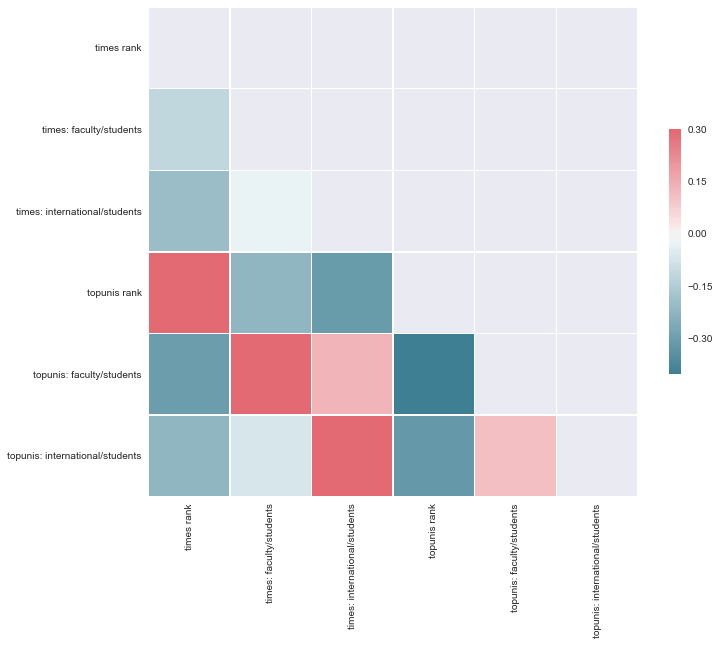

In [60]:
#Keep only bottom triangle
mask = np.zeros_like(cross_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cross_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

We can see at one glance that the variables in the times and in the topuniversities ranking are correlated. 

## Exercise 5 : Best Universities

To get the best university considering both rankings, we will create a new dataframe using the merged one using the name (both of them as we have NaB cases for universities that are only in one or the other frame) and both rankings.

In [61]:
best_uni = merged_frame[['aliases', 'times rank', 'topunis rank']]

Now, we need to add two columns. The first one will be a mean of both ranks, and the second the "distance" between both ranks. This is because if we have a mean of 3.5, it could be because the ranks are 5 and 2, but also because the rank could be 4 and 3. Thus, the university sould be considered "better" (as it is more constistenly good) if the distance between both ranks is smaller.

Note also that if we consider all universities, even the ones not in both sets, we will have NaN values in the frame. This is okay, as we will consider the university to not be "good enough", and thus not in the best. Also, the distance between the two rankings would be infinite and thus NaN is the most correct value.

In [62]:
def calc_mean(c1, c2):
    return (c1 + c2) / 2
    
def calc_distance(c1, c2):
    return abs(c1 - c2)

In [66]:
best_uni['rank_mean'] = calc_mean(best_uni.loc[:,'times rank'], best_uni.loc[:,'topunis rank'])
best_uni['rank_dist'] =  calc_distance(best_uni['times rank'], best_uni['topunis rank'])
best_uni.sort_values(['rank_mean', 'rank_dist'], ascending=[True, True]).reset_index(drop=True).head(30)

,aliases,times rank,rank_mean,topunis rank,rank_dist
0,Stanford University,3,2.5,2,1
1,Massachusetts Institute of Technology,5,3.0,1,4
2,California Institute of Technology caltech,3,3.5,4,1
3,University of Cambridge,2,3.5,5,3
4,University of Oxford,1,3.5,6,5
5,Harvard University,6,4.5,3,3
6,Imperial College London,8,8.0,8,0
7,University of Chicago,9,9.0,9,0
8,ETH Zurich – Swiss Federal Institute of Techno...,10,10.0,10,0
9,Princeton University,7,10.0,13,6


Thus, as we can see, the best university considering both rankings would be Stanford University.

Note that the two universities that were first on one of the lists are still in the top 5. Oxford University is in fifth place while Massachusetts Institute of Technology (MIT) is in second. This is true for all of the universities that are in the top 10 (except princeton) as they were in the top 10 of both lists.

### Observing the change in rankings

Here we can observe the change in ranking for the first 40 universities. Left we have the first ranking, right we have the second, and in the middle, the combined ranking.

The graph quickly shows us how the rankings for each university change. We can observe that for top ranked universities, the ranking doesn't change much, where as for lower ranked universities the ranking varies much more between the two.

We can also see that our 'mean' ranking seems to be working. The combined ranking cuts the straight line going from the times ranking for a given university to the top ranking.

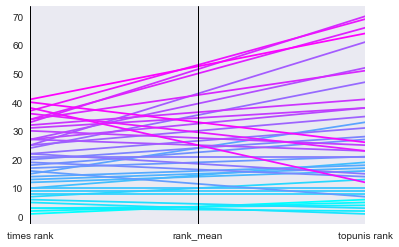

In [64]:
best_uni = best_uni[['aliases', 'times rank', 'rank_mean', 'topunis rank']]
best_uni_10 = best_uni.head(40)
pd.plotting.parallel_coordinates(best_uni_10, 'aliases', colormap=plt.get_cmap("cool"))
plt.gca().legend_.remove()
plt.show()

Here we have the same plot but for all rankings.

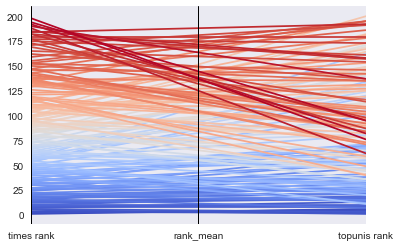

In [65]:
best_uni = best_uni[['aliases', 'times rank', 'rank_mean', 'topunis rank']]
pd.plotting.parallel_coordinates(best_uni, 'aliases', colormap=plt.get_cmap('coolwarm'))
plt.gca().legend_.remove()
plt.show()